## Instalação da biblioteca OSMnx

In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 3.3 MB/s eta 0:00:00


## Importação das bibliotecas

In [ ]:
# Importação das bibliotecas
import osmnx as ox
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

## Baixa o mapa de Natal

In [70]:
# Define o local
place_name = "Natal, Rio Grande do Norte, Brazil"

# Baixa o mapa de Natal
G = ox.graph_from_place(place_name, network_type='drive')

# Define a velocidade para todas as arestas faltando dados
G = ox.routing.add_edge_speeds(G)

# Calcula o tempo de trajeto para todas as arestas
G = ox.routing.add_edge_travel_times(G)

## Estima a emissão de CO2 para cada aresta

In [72]:
# Estima a emissão de CO2
def estima_co2(length, speed_kph=30):
    """
    Estima emissão de CO2 com base no comprimento e velocidade da via.
    Modelo simplificado: consumo em L/km e emissão em g/litro.
    """
    fuel_per_km = 0.06 + 0.002 * speed_kph  # L/km
    co2_per_liter = 2392  # g CO2 / litro de gasolina
    return (length / 1000) * fuel_per_km * co2_per_liter

# Adicionar pesos de CO2 nas arestas
for u, v, k, data in G.edges(keys=True, data=True):
    length = data.get('length', 0)
    speed = data.get('maxspeed', 30)
    if isinstance(speed, list):
        speed = float(speed[0])
    elif isinstance(speed, str):
        try:
            speed = float(speed.split()[0])
        except:
            speed = 30.0
    data['co2'] = estima_co2(length, speed)

## Central de Controle de Zoonoses de Natal

Dado o valor de longitude e latitude da Central de Controle de Zoonoses de Natal, encontra o nó mais próximo do grafo.

In [73]:
central = ox.distance.nearest_nodes(G, -35.262693, 5.7532952)

## Pontos de coleta

In [74]:
pontos_coleta = pd.read_csv('centroid_filtered.csv')
pontos_coleta

,Lat,Lon,Neighborhood,District
0,-5.790850,-35.209797,Alecrim,East
1,-5.796285,-35.196730,Tirol,East
2,-5.788262,-35.190320,Areia Preta,East
3,-5.780528,-35.204124,Ribeira,East
4,-5.767820,-35.200720,Santos Reis,East
...,...,...,...,...
60,-5.827432,-35.277770,Guarapes,West
61,-5.820680,-35.265945,Felipe Camarão,West
62,-5.738779,-35.270610,N. S. Apresentação,North
63,-5.726151,-35.250305,Lagoa Azul,North


## Distribuição aleatória dos pontos de coleta entre os dez colaboradores

In [75]:
pontos_coleta_embaralhados = pontos_coleta.sample(frac=1, random_state=42).reset_index(drop=True)
divisao_0 = np.array_split(pontos_coleta_embaralhados, 10)

In [76]:
# Pontos de coleta do sétimo colaborador.
divisao_0[6]


,Lat,Lon,Neighborhood,District
41,-5.880827,-35.192870,Ponta Negra,South
42,-5.818177,-35.243366,Felipe Camarão,West
43,-5.812769,-35.222580,Lagoa Nova,South
44,-5.840944,-35.203610,Lagoa Nova,South
45,-5.876882,-35.185112,Ponta Negra,South
46,-5.796285,-35.196730,Tirol,East


## Distribuição dos pontos de coleta seguindo lógica espacial

Nessa segunda divisão é utilizado um critério de distribuição espacial dos pontos de coleta. Busca-se deixar cada colaborador com aproximadamente 6 pontos de coleta, podendo variar de 4 a 8. Todos os pontos de coleta de um bairro estão com um mesmo colaborador. Quando não há muitos pontos em um bairro, um colaborador pode ficar com dois ou mais bairros, quase sempre da mesma zona -- à exceção do colaborador que fica com os bairros Planalto (Oeste) e Pitimbu (Sul). Excepcionalmente, um colaborador fica com todos os bairros da zona Leste.

* Colaborador 1: bairro Nossa Senhora da Apresentação;
* Colaborador 2: bairro Lagoa Azul;
* Colaborador 3: bairros Igapó e Potengi;
* Colaborador 4: bairros Pajuçara e Redinha;
* Colaborador 5: bairro Guarapes;
* Colaborador 6: bairros Nazaré, Quintas e Bom Pastor;
* Colaborador 7: bairros Felipe Camarão e Cidade Nova;
* Colaborador 8: bairros Planalto e Pitimbu;
* Colaborador 9: bairros Candelária, Lagoa Nova e Nova Descoberta;
* Colaborador 10: zona Leste (bairros Alecrim, Tirol, Ribeira, Areia Preta e Santos Reis).

In [77]:
divisao_1 = [[] for _ in range(10)]
divisao_1[0] = pontos_coleta[pontos_coleta['Neighborhood'] == 'N. S. Apresentação']
divisao_1[1] = pontos_coleta[pontos_coleta['Neighborhood'] == 'Lagoa Azul']
divisao_1[2] = pontos_coleta[(pontos_coleta['Neighborhood'] == 'Igapó')
                             | (pontos_coleta['Neighborhood'] == 'Potengi')]
divisao_1[3] = pontos_coleta[(pontos_coleta['Neighborhood'] == 'Pajuçara')
                             | (pontos_coleta['Neighborhood'] == 'Redinha')]
divisao_1[4] = pontos_coleta[pontos_coleta['Neighborhood'] == 'Guarapes']
divisao_1[5] = pontos_coleta[(pontos_coleta['Neighborhood'] == 'Nazaré')
                             | (pontos_coleta['Neighborhood'] == 'Quintas')
                             | (pontos_coleta['Neighborhood'] == 'Bom Pastor')]
divisao_1[6] = pontos_coleta[(pontos_coleta['Neighborhood'] == 'Felipe Camarão')
                             | (pontos_coleta['Neighborhood'] == 'Cidade Nova')]
divisao_1[7] = pontos_coleta[(pontos_coleta['Neighborhood'] == 'Planalto')
                             | (pontos_coleta['Neighborhood'] == 'Pitimbu')]
divisao_1[8] = pontos_coleta[(pontos_coleta['Neighborhood'] == 'Candelária')
                             | (pontos_coleta['Neighborhood'] == 'Lagoa Nova')
                             | (pontos_coleta['Neighborhood'] == 'Nova Descoberta')]
divisao_1[9] = pontos_coleta[pontos_coleta['District'] == 'East']

In [78]:
divisao_1[9]

,Lat,Lon,Neighborhood,District
0,-5.790850,-35.209797,Alecrim,East
1,-5.796285,-35.196730,Tirol,East
2,-5.788262,-35.190320,Areia Preta,East
3,-5.780528,-35.204124,Ribeira,East
4,-5.767820,-35.200720,Santos Reis,East
30,-5.804895,-35.225872,Alecrim,East
31,-5.803490,-35.217167,Alecrim,East
34,-5.805481,-35.220963,Alecrim,East


## Geração de rotas usando Dijkstra

Geração de rotas usando comprimento, tempo e CO2 como pesos.

In [79]:
# Geração de rota usando Dijkstra e distância como peso
def rota_dijkstra_length(G, central, pontos):
    lista_pontos = pontos.apply(lambda row: ox.distance.nearest_nodes(G, row['Lon'], row['Lat']), axis=1).tolist()
    sequencia = [central] + lista_pontos + [central]
    rota = []
    for i in range(len(sequencia) - 1):
        trecho = nx.dijkstra_path(G, source=sequencia[i], target=sequencia[i+1], weight='length')
        rota.extend(trecho[:-1])  # evitar repetição de nós
    rota.append(central)

    return rota

# Geração de rota usando Dijkstra e distância como peso
def rota_dijkstra_time(G, central, pontos):
    lista_pontos = pontos.apply(lambda row: ox.distance.nearest_nodes(G, row['Lon'], row['Lat']), axis=1).tolist()
    sequencia = [central] + lista_pontos + [central]
    rota = []
    for i in range(len(sequencia) - 1):
        trecho = nx.dijkstra_path(G, source=sequencia[i], target=sequencia[i+1], weight='travel_time')
        rota.extend(trecho[:-1])  # evitar repetição de nós
    rota.append(central)

    return rota

# Geração de rota usando Dijkstra e CO2 como peso
def rota_dijkstra_co2(G, central, pontos):
    lista_pontos = pontos.apply(lambda row: ox.distance.nearest_nodes(G, row['Lon'], row['Lat']), axis=1).tolist()
    sequencia = [central] + lista_pontos + [central]
    rota = []
    for i in range(len(sequencia) - 1):
        trecho = nx.dijkstra_path(G, source=sequencia[i], target=sequencia[i+1], weight='co2')
        rota.extend(trecho[:-1])  # evitar repetição de nós
    rota.append(central)

    return rota

## Geração de rotas usando A*

Geração de rotas usando comprimento, tempo e CO2 como pesos.

In [80]:
# Geração de rota usando A* e distância como peso
def rota_astar_length(G, central, pontos):
    lista_pontos = pontos.apply(lambda row: ox.distance.nearest_nodes(G, row['Lon'], row['Lat']), axis=1).tolist()
    sequencia = [central] + lista_pontos + [central]
    rota = []
    for i in range(len(sequencia) - 1):
        trecho = nx.astar_path(G, source=sequencia[i], target=sequencia[i+1], weight='length')
        rota.extend(trecho[:-1])  # evitar repetição de nós
    rota.append(central)

    return rota

# Geração de rota usando A* e distância como peso
def rota_astar_time(G, central, pontos):
    lista_pontos = pontos.apply(lambda row: ox.distance.nearest_nodes(G, row['Lon'], row['Lat']), axis=1).tolist()
    sequencia = [central] + lista_pontos + [central]
    rota = []
    for i in range(len(sequencia) - 1):
        trecho = nx.astar_path(G, source=sequencia[i], target=sequencia[i+1], weight='travel_time')
        rota.extend(trecho[:-1])  # evitar repetição de nós
    rota.append(central)

    return rota

# Geração de rota usando A* e CO2 como peso
def rota_astar_co2(G, central, pontos):
    lista_pontos = pontos.apply(lambda row: ox.distance.nearest_nodes(G, row['Lon'], row['Lat']), axis=1).tolist()
    sequencia = [central] + lista_pontos + [central]
    rota = []
    for i in range(len(sequencia) - 1):
        trecho = nx.astar_path(G, source=sequencia[i], target=sequencia[i+1], weight='co2')
        rota.extend(trecho[:-1])  # evitar repetição de nós
    rota.append(central)

    return rota

In [81]:
# Geração das rotas
colunas = ['Aleatória', 'Dijkstra (comprimento)', 'Dijkstra (tempo)',
           'Dijkstra (CO2)', 'A* (comprimento)', 'A* (tempo)', 'A* (CO2)']
rotas = pd.DataFrame(columns=colunas)
for i in range(10):
    novas_rotas = [rota_dijkstra_length(G, central, divisao_0[i]),
                   rota_dijkstra_length(G, central, divisao_1[i]),
                   rota_dijkstra_time(G, central, divisao_1[i]),
                   rota_dijkstra_co2(G, central, divisao_1[i]),
                   rota_astar_length(G, central, divisao_1[i]),
                   rota_astar_time(G, central, divisao_1[i]),
                   rota_astar_co2(G, central, divisao_1[i])]
    rotas.loc[i] = novas_rotas

## Avalia rotas (distância, tempo ou CO2)

In [82]:
# Somar atributos ao longo de uma rota
def somar_atributo_em_rota(G, rota, atributo='length'):
    total = 0
    for i in range(len(rota) - 1):
        u, v = rota[i], rota[i+1]
        arestas = G.get_edge_data(u, v)
        if arestas:
            menor_valor = min(d[atributo] for d in arestas.values() if atributo in d)
            total += menor_valor
        else:
            raise ValueError(f"Aresta {u} → {v} não encontrada.")
    return total


In [83]:
# Somar atributos de todos os colaboradores
def metrica_estrategia(G, rotas, estrategia=0, atributo='length'):
    total = 0
    for i in range(10):
        total += somar_atributo_em_rota(G, rotas.iloc[i][estrategia], atributo=atributo)
    return total

In [84]:
metrica_estrategia(G, rotas, estrategia=2, atributo='travel_time')

29918.822116970558

In [87]:
metricas = ['Comprimento (m)', 'Tempo (s)', 'CO2 (g/L)']
resultados = pd.DataFrame(columns=metricas)
for i in range(7):
    resultados.loc[i] = [metrica_estrategia(G, rotas, estrategia=i, atributo='length'),
                         metrica_estrategia(G, rotas, estrategia=i, atributo='travel_time'),
                         metrica_estrategia(G, rotas, estrategia=i, atributo='co2')]

In [88]:
resultados

,Comprimento (m),Tempo (s),CO2 (g/L)
0,984640.485527,78640.542504,319178.634045
1,398911.580853,33188.609233,125995.211129
2,419209.173417,29918.822117,135639.856244
3,406232.369992,34874.133241,123727.286018
4,398911.580853,33188.609233,125995.211129
5,419209.173417,29918.822117,135639.856244
6,406232.369992,34874.133241,123727.286018


## Plota uma rota

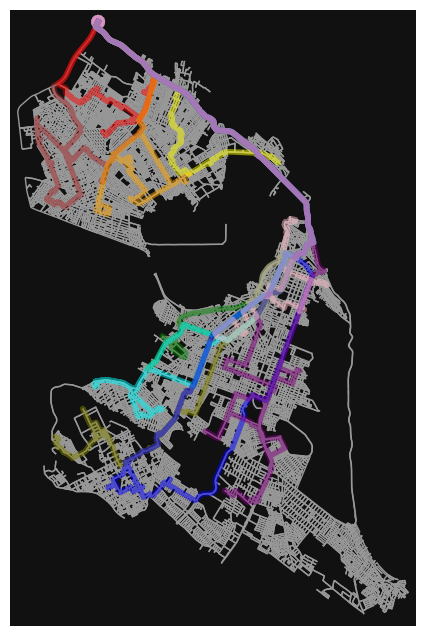

In [89]:
colors = ['brown', 'red', 'orange', 'yellow', 'olive', 'green', 'cyan',
          'blue', 'purple', 'pink']
fig1, ax1 = ox.plot_graph_routes(G, routes=[rotas.loc[i, 'Dijkstra (tempo)'] for i in range(10)],
                                 route_colors=colors,
                                 route_linewidth=6,
                                 node_size=0,
                                 show=False,
                                 close=False)

# Cria linhas fictícias para legenda
#astar_length_line = mlines.Line2D([], [], color='r', label='A* (Length)')
#astar_time_line = mlines.Line2D([], [], color='y', label='A* (Travel_Time)')

# Adiciona a legenda ao gráfico
#ax1.legend(handles=[astar_length_line, astar_time_line], loc='upper right')

# Exibe o gráfico com a legenda
plt.show()